# 熟悉 Polars 的概念和 API

## 结论先行
本 [notebook](https://github.com/wangzaixiang/notebooks/blob/main/polars/polars-1.ipynb) 是通过 jupyter notebook 的方式，
来学习 polars 的API，并理解其概念。

1. polars 有3种求值的上下文：
   - Selection Context: `df.select(...)`, `df.with_columns(...)`
   - Filter Context:  `df.filter(...) `
   - Group By(Aggregation Context)：`df.group_by(...).agg(...)`，每一个分组可以理解为一个child dataframe
   
2. 在这三个上下文中，每个表达式的求值结果是 Series-N 或者 Series-1。Series-N 会自动广播为 Series-N。
   - 表达式可以是基本的 pl.col("name") 这种求值为 Series-N
   - 表达式可以是聚合函数，例如 pl.sum("nrs")， 求值为 Series-1
   - 可以是窗口函数，例如 pl.col("Close").last().over("YM").alias("last_close")，求值为 Series-N
   - 表达式可以是复杂的操作 pl.col("random").filter(pl.col("names").is_not_null()) 
   - Series-1 的求值结果会被广播为 Series-N, 所有的 Series-N 的 N 值必须与 DataFrame 的记录数相同。否则会报错。

3. 表达式是在 dataframe 的基础上进行求值，而不是在 row based 上进行求值。即使是 Series-1 也是 (df -> Series-1)，而非
   ( row -> Series-1 )

4. polars 不同于 SQL select 的执行流程，后者有一个严格的执行顺序定义： 
    - from -> where -> group by -> having -> select -> window -> order by
    - polars 中，每个操作是独立的，不同的顺序组合，会产生不同的结果。
    - 在 polars 中, select 求值上下文中可以求值的能力，包括了 字段级、聚合级、窗口级的能力，一定程度上比 SQL 更强大。
    - 在 filter/aggr 求值上下文中，也可以进行类似的计算。

5. TODO
   - [ ] polars 对窗口函数的求值是如何进行的？是否最优？
   - [ ] polars 是否有对简单的 group_by sum 操作有进行优化，避免生成中间的 child dataframe?
   - [ ] 对一个 join 后的 dataframe, 是否会有减枝的操作？及无用到的表会自动减枝？


## 1. Contexts

如下的概念基于如下的示例数据集：

In [1]:
import polars as pl
import numpy as np

df = pl.DataFrame(
    {
        "nrs": [1, 2, 3, None, 5],
        "names": ["foo", "ham", "spam", "egg", None],
        "random": np.random.rand(5),
        "groups": ["A", "A", "B", "C", "B"],
    }
)
df

nrs,names,random,groups
i64,str,f64,str
1,"""foo""",0.998578,"""A"""
2,"""ham""",0.061645,"""A"""
3,"""spam""",0.927885,"""B"""
null,"""egg""",0.412684,"""C"""
5,null,0.432504,"""B"""


### 1.1 Selection Context



#### 1) Series-N and Series-1 expression

In [8]:
df.select(
    pl.col("nrs"),
    pl.col("names"),
    pl.col("random").sum().alias("total"),
    pl.col("groups")
)

nrs,names,total,groups
i64,str,f64,str
1,"""foo""",2.23031,"""A"""
2,"""ham""",2.23031,"""A"""
3,"""spam""",2.23031,"""B"""
null,"""egg""",2.23031,"""C"""
5,null,2.23031,"""B"""


解析：
1. df.select( pl.col("nrs") ) 返回的结果是一个 Series，其长度为 N（记录数）
2. df.select( pl.col("random").sum() ) 返回的结果是 Series[1] 或者 Scalar，Scalar值会广播成为 Series[N]。

因此，在 Select 中的表达式，或者返回 Series[N]， 或者返回 Series[1]。

In [2]:
df.select(
    pl.sum("nrs"),                                # Scalar
    pl.col("names").alias("names1"),
    pl.col("names").sort(),                       # Series[N]
    pl.col("names").first().alias("first name"),  # Scalar
    (pl.mean("nrs") * 10).alias("10xnrs"),        # Scalar
)

nrs,names1,names,first name,10xnrs
i64,str,str,str,f64
11,"""foo""",null,"""foo""",27.5
11,"""ham""","""egg""","""foo""",27.5
11,"""spam""","""foo""","""foo""",27.5
11,"""egg""","""ham""","""foo""",27.5
11,null,"""spam""","""foo""",27.5


In [12]:
# example mixes Series-N and Series-1 Expression
df.select(
    pl.sum("nrs"),                                                        # Scalar
    pl.col("names").sort(),                                               # Series[N]
    pl.col("names").first().alias("first name"),                          # Scalar
    (pl.col("random") / pl.col("random").sum() * 100).alias("pecents"),   # Series[N] / Scalar => Series[N]
    (pl.mean("nrs") * 10).alias("10xnrs"),                                # Scalar
)

nrs,names,first name,pecents,10xnrs
i64,str,str,f64,f64
11,null,"""foo""",37.248716,27.5
11,"""egg""","""foo""",2.337091,27.5
11,"""foo""","""foo""",11.178078,27.5
11,"""ham""","""foo""",37.932039,27.5
11,"""spam""","""foo""",11.304075,27.5


基于向量的广播机制，可以在单个表达式中结合使用 Series-N 表达式 和 Series-1 表达式，这种能力，要在SQL中表达出来，还是比较困难的。（**从这个角度来看，
Polars的表达能力相比 SQL 更强大一些，两者的计算模型并不相同**）。

#### 2) APIS

`df.select( ... )`  # 仅选择部分列

`df.with_columns( ... ) ` # 保留所有列，并创新新的列(如果列名重复，则覆盖掉原有的列)

In [15]:
df.with_columns(
    pl.col("random").sum(),   # 没有取别名时，这个新的列的列明也叫做 random，因此，在结果中会覆盖掉原有 random 列。
)

nrs,names,random,groups
i64,str,f64,str
1,"""foo""",2.23031,"""A"""
2,"""ham""",2.23031,"""A"""
3,"""spam""",2.23031,"""B"""
null,"""egg""",2.23031,"""C"""
5,null,2.23031,"""B"""


In [3]:
# the code not works
df.select(
    pl.col("nrs").filter(pl.col("names").is_not_null()),       # the series length is 4, not 5
    pl.col("names"),
    pl.col("random").sum().alias("total"),
    pl.col("groups")
)

# ComputeError: Series length 4 doesn't match the DataFrame height of 5

ComputeError: Series length 4 doesn't match the DataFrame height of 5

这段代码无法正确执行：
1. df 的长度为 5
2. `df.select( pl.col("nrs").filter( pl.col("names").is_not_null() )` 返回的 Series 长度为4。Series-N 与 DataFrame 不匹配。
这种情况是不能使用广播的方式进行对齐的，因此，这段代码无法正确执行。

### 1.2 Filter Context

Filter Context 的表达式求值为 boolean， 类似于 f: row -> boolean


In [16]:
df.filter(pl.col("nrs") > 2)

nrs,names,random,groups
i64,str,f64,str
3,"""spam""",0.249306,"""B"""
5,null,0.252116,"""B"""


In [21]:
# 可以在 filter 中使用聚合函数，窗口函数，其用法与 select 中一致。
df.filter(pl.col("random").sum().over("groups") > 0.8)

nrs,names,random,groups
i64,str,f64,str
1,"""foo""",0.155879,"""A"""
2,"""ham""",0.711329,"""A"""


***需要补充分析***

在 Filter 中也存在 Series-N 和 Series-1 的表达式问题，可以理解为：filter 是计算出一个 Series-N[Boolean]，表达式的每一个部分或者求值为：Series-1（广播）或者 Series-N。
当结合一些复杂的表达式时，例如 a and b or c，其中 a,b, c 可能是 Series-N， 也可能是 Series-1.
求值方式： 1. 先对所有基础的 Logic Expression 进行求值，其或者为 Series-N, 或者为 Series-1。 
2. 广播后，再求值 Series-N

问题：
1. 在上面的例子中，select 上下文中可以使用 filter, sum, 以及窗口函数等，那么这些函数是否在 filter 中也可以使用？
2. 如果既有 select 计算，又有 filter 计算，那么这两个计算是否有先后顺序？
我们可以查看如下的示例：

In [11]:
df1 = df.select(
    pl.sum("nrs"),                                # Scalar
    pl.col("names").alias("names1"),
    pl.col("names").sort(),                       # Series[N]
    pl.col("names").first().alias("first name"),  # Scalar
    (pl.mean("nrs") * 10).alias("10xnrs"),        # Scalar
) .filter(pl.col("nrs") > 2 )

df2 = df.filter(pl.col("nrs") > 2).select(
    pl.sum("nrs"),                                # Scalar
    pl.col("names").alias("names1"),
    pl.col("names").sort(),                       # Series[N]
    pl.col("names").first().alias("first name"),  # Scalar
    (pl.mean("nrs") * 10).alias("10xnrs"),        # Scalar
)

shape: (5, 5)
┌─────┬────────┬───────┬────────────┬────────┐
│ nrs ┆ names1 ┆ names ┆ first name ┆ 10xnrs │
│ --- ┆ ---    ┆ ---   ┆ ---        ┆ ---    │
│ i64 ┆ str    ┆ str   ┆ str        ┆ f64    │
╞═════╪════════╪═══════╪════════════╪════════╡
│ 11  ┆ foo    ┆ null  ┆ foo        ┆ 27.5   │
│ 11  ┆ ham    ┆ egg   ┆ foo        ┆ 27.5   │
│ 11  ┆ spam   ┆ foo   ┆ foo        ┆ 27.5   │
│ 11  ┆ egg    ┆ ham   ┆ foo        ┆ 27.5   │
│ 11  ┆ null   ┆ spam  ┆ foo        ┆ 27.5   │
└─────┴────────┴───────┴────────────┴────────┘
shape: (2, 5)
┌─────┬────────┬───────┬────────────┬────────┐
│ nrs ┆ names1 ┆ names ┆ first name ┆ 10xnrs │
│ --- ┆ ---    ┆ ---   ┆ ---        ┆ ---    │
│ i64 ┆ str    ┆ str   ┆ str        ┆ f64    │
╞═════╪════════╪═══════╪════════════╪════════╡
│ 8   ┆ spam   ┆ null  ┆ spam       ┆ 40.0   │
│ 8   ┆ null   ┆ spam  ┆ spam       ┆ 40.0   │
└─────┴────────┴───────┴────────────┴────────┘


In [15]:
df1

nrs,names1,names,first name,10xnrs
i64,str,str,str,f64
11,"""foo""",null,"""foo""",27.5
11,"""ham""","""egg""","""foo""",27.5
11,"""spam""","""foo""","""foo""",27.5
11,"""egg""","""ham""","""foo""",27.5
11,null,"""spam""","""foo""",27.5


In [13]:
df2

nrs,names1,names,first name,10xnrs
i64,str,str,str,f64
8,"""spam""",null,"""spam""",40.0
8,null,"""spam""","""spam""",40.0


从上面的这个例子中， 我们可以看到 调整顺序后的两个结果是完全不一样的，这个也说明了与 SQL Select 并不一样，在 Pola RS 中，
select 与 filter 是独立的操作，df.select(...).filter(...) 与 df.filter(...).select(...) 是不一样的。

这与 SQL 中 select * from table where ... 的执行顺序是不一样的。一条SQL 语句有一个预定的执行顺序，参见：
[SELECT 语句执行流程](https://pic2.zhimg.com/80/v2-8faf44f913ce39eef7bab322e4a1b4f9_1440w.webp)
在这个执行流程中，select 子句是在filter 之后，然后group by，having，在 having 过滤之后执行的，但在窗口函数执行之前。
而 polars 则完全不同，每个 data frame 操作是独立的，不同的顺序组合，会产生不同的结果。

当然，在 Lazy Evaluation 中，最后执行计划会对这些操作进行优化，生成一个最优的执行计划。但逻辑上来看，这些操作是独立的。

### 1.3 Aggragation Context

在 `group_by`之后， DataFrame 会转化为 GroupBy， agg 操作会再次将 GroupBy 转换为 DataFrame。

每个 agg 表达式的上下文是单个分组， 其返回值是 Series-1。 如果某个表达式求值为 Series-N，将最后转换为 Series-1。（大部分是一个字符串拼接的操作）

In [23]:
df.group_by("groups").agg(
    pl.col("nrs"),  
    pl.col("random"), 
    pl.col("names"),
)

groups,nrs,random,names
str,list[i64],list[f64],list[str]
"""A""","[1, 2]","[0.830762, 0.052124]","[""foo"", ""ham""]"
"""C""",[null],[0.846002],"[""egg""]"
"""B""","[3, 5]","[0.249306, 0.252116]","[""spam"", null]"


在 group_by 之后的 DF 其上下文为 List[(key, rows)] 的形式，在这个例子中，我们没有进行聚合操作，因此，返回的结果是每个组中的字段的一个列表形式。这个在实际中意义不大，因为数据量很大时，这个值会很长。但在这个教程中，可以帮助理解后续的聚合函数如何工作。

In [36]:
df.group_by("groups").agg(
    pl.sum("nrs"),                                                                      # sum nrs by groups
    pl.col("random"),
    pl.col("random").count().alias("random_count"),                                            # count group members
    pl.col("random").filter(pl.col("names").is_not_null()).alias("random_hasname"),
    pl.col("random").filter(pl.col("names").is_not_null()).sum().name.suffix("_sum"),   # sum random where name != null
    pl.col("nrs").alias("all nrs"),                                                     # Series-N 会自动转换为 Series-1
    pl.col("names").reverse().alias("reversed names"),                                  # Series-N 会自动转换为 Series-1,
    (pl.col("random").filter(pl.col("names").is_not_null()) / 
     pl.col("random").sum() * 100
    ).alias("hasname_percents"),                                                        # 比较复杂的表达式 
    pl.col("random").filter(pl.col("names").is_not_null())
      .filter(pl.col("nrs") >= 2).alias("random_hasname_tailer")                        # 理解 filter 
)

groups,nrs,random,random_count,random_hasname,random_sum,all nrs,reversed names,hasname_percents,random_hasname_tailer
str,i64,list[f64],u32,list[f64],f64,list[i64],list[str],list[f64],list[f64]
"""C""",0,[0.846002],1,[0.846002],0.846002,[null],"[""egg""]",[100.0],[]
"""B""",8,"[0.249306, 0.252116]",2,[0.249306],0.249306,"[3, 5]","[null, ""spam""]",[49.719785],[0.249306]
"""A""",3,"[0.830762, 0.052124]",2,"[0.830762, 0.052124]",0.882886,"[1, 2]","[""ham"", ""foo""]","[94.096138, 5.903862]",[0.052124]


这个示例中有几个Expression的理解会比较复杂，需要理解 Series-N 和 Series-1 的计算过程。 
1. `pl.sum("nrs")` 在当前分组中，求值为 Series-1
2. `pl.col("random").filter(pl.col("names").is_not_null()).sum().name.suffix("_sum")`
    1.  `X = pl.col("random")` 求值为 Series-N
    2.  `Y = X.filter(pl.col("names").is_not_null())` 求值为 Series-N
    3.  `Y.sum()` 求值为 Series-1
3. `pl.col("random").filter(pl.col("names").is_not_null()).filter(pl.col("nrs") >= 2).alias("random_hasname_tailer") `
    1.  `X = pl.col("random")`: Series-N
    2.  `Y = X.filter(pl.col("names").is_not_null())` : X 的环境中不仅仅包括 random列，也包括了其他的列。
    3.  `Z = Y.filter(pl.col("nrs") >= 2)`  : Z：从Y 中派生出来，Y 中也包含了其他的列。
  
这个 filter 的上下文确实非常强大，后续在阅读代码时，需要理解这个执行的逻辑。

## 2. Expressions

理解了 context 之后，expression 的多样性就显得没有那么复杂了，否则的话，一大堆的 expression 会让人眼花缭乱。

可以分为如下几类：
- operators: +, -, *, / etc. 
- column selections: p.col("name"), p.all()
- functions, case when,
- casting
- strings
- aggregations
- missing data
- window functions
- folds
- lists
- UDF
- struts


In [5]:
df

nrs,names,random,groups
i64,str,f64,str
1,"""foo""",0.332095,"""A"""
2,"""ham""",0.807228,"""A"""
3,"""spam""",0.174601,"""B"""
null,"""egg""",0.839158,"""C"""
5,null,0.498681,"""B"""


In [6]:
out = df.group_by("groups").agg(
    pl.sum("nrs"),  # sum nrs by groups
    pl.col("random").count().alias("count"),  # count group members
    # sum random where name != null
    pl.col("random").filter(pl.col("names").is_not_null()).sum().name.suffix("_sum"),
    pl.col("names").reverse().alias("reversed names"),
)
print(out)

shape: (3, 5)
┌────────┬─────┬───────┬────────────┬────────────────┐
│ groups ┆ nrs ┆ count ┆ random_sum ┆ reversed names │
│ ---    ┆ --- ┆ ---   ┆ ---        ┆ ---            │
│ str    ┆ i64 ┆ u32   ┆ f64        ┆ list[str]      │
╞════════╪═════╪═══════╪════════════╪════════════════╡
│ A      ┆ 3   ┆ 2     ┆ 1.139323   ┆ ["ham", "foo"] │
│ C      ┆ 0   ┆ 1     ┆ 0.839158   ┆ ["egg"]        │
│ B      ┆ 8   ┆ 2     ┆ 0.174601   ┆ [null, "spam"] │
└────────┴─────┴───────┴────────────┴────────────────┘


In [8]:
df.select( pl.col("names").filter( pl.col("nrs") >= 3 ) )

names
str
"""spam"""
null


In [10]:
df.filter( pl.col("nrs") >=3 ).select( pl.col("names") )

names
str
"""spam"""
null


In [14]:
out = df.group_by("groups").agg(
    pl.col("nrs").sum(),  # sum nrs by groups
    pl.count("random").alias("count"),  # count group members
    # sum random where name != null
    pl.col("random").filter(pl.col("names").is_not_null()).sum().name.suffix("_sum"),
    pl.col("names").reverse().alias("reversed names"),
)
print(out)

shape: (3, 5)
┌────────┬─────┬───────┬────────────┬────────────────┐
│ groups ┆ nrs ┆ count ┆ random_sum ┆ reversed names │
│ ---    ┆ --- ┆ ---   ┆ ---        ┆ ---            │
│ str    ┆ i64 ┆ u32   ┆ f64        ┆ list[str]      │
╞════════╪═════╪═══════╪════════════╪════════════════╡
│ A      ┆ 3   ┆ 2     ┆ 1.139323   ┆ ["ham", "foo"] │
│ C      ┆ 0   ┆ 1     ┆ 0.839158   ┆ ["egg"]        │
│ B      ┆ 8   ┆ 2     ┆ 0.174601   ┆ [null, "spam"] │
└────────┴─────┴───────┴────────────┴────────────────┘


In [6]:
from datetime import date ;
df2 = (
    pl.date_range(
        start=date(2021, 1, 1),
        end=date(2021, 12, 31),
        interval="1d",
        eager=True,
    )
    .alias("time")
    .to_frame()
)

df2

time
date
2021-01-01
2021-01-02
2021-01-03
2021-01-04
2021-01-05
…
2021-12-27
2021-12-28
2021-12-29


## 3. Eager or Lazy

## 4. Transformation

## 5. Window Function

In [4]:
apple_stocks = (
    pl.scan_csv("./apple_stock.csv")
)

In [5]:
q = (apple_stocks
    .select( pl.col("Date").str.to_datetime("%Y-%m-%d"), "Close")
    .with_columns(pl.col("Date").dt.to_string("%Y-%m").alias("YM"))
    .sort("Date")
    .with_columns( pl.col("Close").last().over("YM").alias("last_close") )
    .select("YM", "last_close")
    .unique().sort("YM")
)

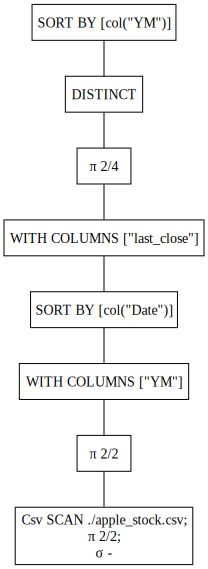

In [9]:
q.show_graph()

# q.explain()

## 6. Operator and Functions